In [ ]:
import numpy as np
import json
import re
from typing import Optional


def extract_gold_truth(target) -> str:
    return target.split("####")[-1].strip()


def flexible_extract(resp: str) -> Optional[str]:
    matches = re.findall(r"(-?[$0-9.,]{2,})|(-?[0-9]+)", resp)
    if matches:
        num_str = matches[-1][0] or matches[-1][1]
        num_str = num_str.replace(",", "").replace("$", "")
        return num_str
    return None


def get_accuracy_list(file: str) -> np.array:
    acc = []
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            sample = json.loads(line)
            gold = extract_gold_truth(sample["target"])
            answers = [flexible_extract(resp[0]) for resp in sample["resps"]]
            is_correct = int(gold in answers)
            acc.append(is_correct)
    return np.array(acc)


baseline_file = "results/gsm8k/meta-llama__Llama-3.1-8B-Instruct/samples_gsm8k_2025-04-28T13-16-34.698040.jsonl"
sd_file = "results/gsm8k/spec_variant/samples_gsm8k_2025-06-20T18-32-37.203127.jsonl"

baseline_acc = get_accuracy_list(baseline_file)
sd_acc = get_accuracy_list(sd_file)

delta = sd_acc - baseline_acc
n = len(delta)
boot_iters = 10000
boot_deltas = []

for _ in range(boot_iters):
    sample = np.random.choice(delta, size=n, replace=True)
    boot_deltas.append(np.mean(sample))

boot_deltas = np.array(boot_deltas)
ci_lower = np.percentile(boot_deltas, 2.5)
ci_upper = np.percentile(boot_deltas, 97.5)
mean_diff = np.mean(boot_deltas)

print(f"Средняя ΔТочность (SD - Baseline): {mean_diff:.4f}")
print(f"95% доверительный интервал: [{ci_lower:.4f}, {ci_upper:.4f}]")

Средняя ΔТочность (SD - Baseline): 0.0061
95% доверительный интервал: [-0.0076, 0.0205]


In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


conn = sqlite3.connect("database.db")
cursor = conn.cursor()

In [27]:
get_gsm8k_scores = """
SELECT 
    m.model_name,
    q.quantization_type,
    a.gsm8k_score,
    a.date
FROM accuracy a
JOIN models m ON a.model_id = m.model_id
JOIN quantizations q ON a.quantization_id = q.quantization_id
ORDER BY m.model_name, q.quantization_type
"""

df = pd.read_sql_query(get_gsm8k_scores, conn)
df = (
    df.groupby(["model_name", "quantization_type"])
    .aggregate({"gsm8k_score": "mean"})
    .reset_index()
)

# Temporal fix
df = df[df.model_name != "Llama-3.2-3B-Instruct"]

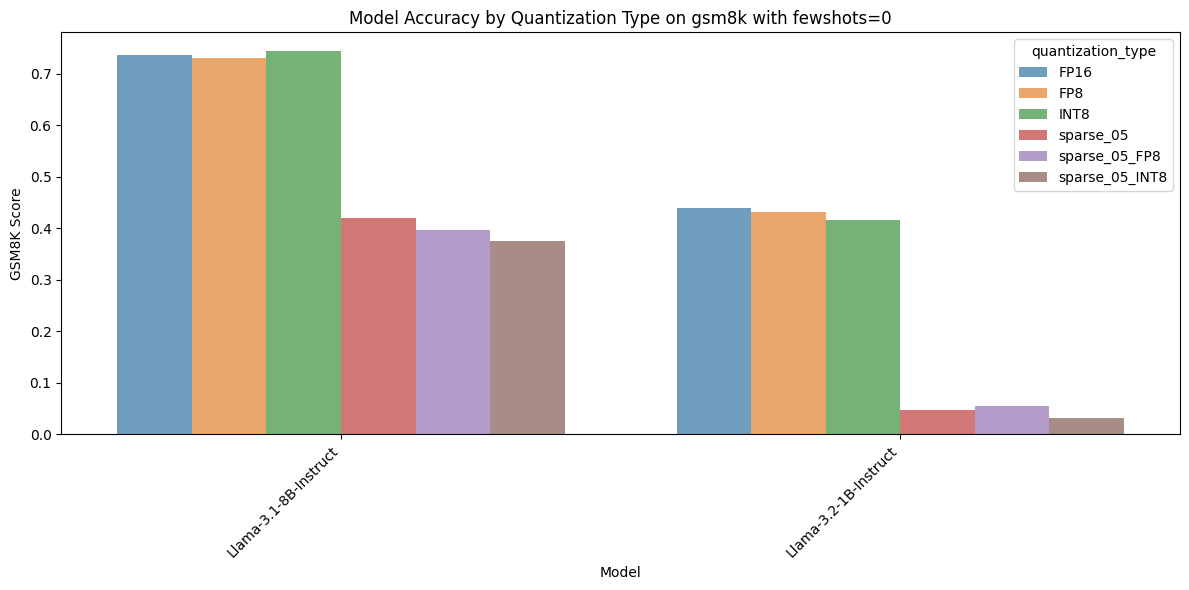

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="model_name",
    y="gsm8k_score",
    hue="quantization_type",
    alpha=0.7,
)

plt.title("Model Accuracy by Quantization Type on gsm8k with fewshots=0")
plt.xlabel("Model")
plt.ylabel("GSM8K Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [41]:
get_sd_metrics = """
SELECT 
    sp.date,
    tm.model_name as target_model,
    tq.quantization_type as target_quantization,
    dm.model_name as draft_model,
    dq.quantization_type as draft_quantization,
    d.dataset_type,
    sp.mean_acceptance_length,
    sp.time_taken,
    sp.rate_at_1position,
    sp.rate_at_2position,
    sp.rate_at_3position,
    sp.rate_at_4position,
    sp.rate_at_5position
FROM sd_performances sp
JOIN sd_setups ss ON sp.sd_setup_id = ss.sd_setup_id
JOIN models tm ON ss.target_model_id = tm.model_id
JOIN quantizations tq ON ss.target_quantization_id = tq.quantization_id
JOIN models dm ON ss.draft_model_id = dm.model_id
JOIN quantizations dq ON ss.draft_quantization_id = dq.quantization_id
JOIN datasets d ON ss.dataset_id = d.dataset_id
ORDER BY sp.date DESC
"""

df = pd.read_sql_query(get_sd_metrics, conn)


df = df.drop_duplicates()
df = df[df.target_quantization == "FP8"]

df = (
    df.groupby(
        [
            "target_model",
            "target_quantization",
            "draft_model",
            "draft_quantization",
            "dataset_type",
        ]
    )
    .aggregate(
        {
            "time_taken": "mean",
            "rate_at_1position": "mean",
            "rate_at_2position": "mean",
            "rate_at_3position": "mean",
            "rate_at_4position": "mean",
            "rate_at_5position": "mean",
            "mean_acceptance_length": "mean",
        }
    )
    .reset_index()
)
df["full_draft_name"] = df["draft_model"] + "_" + df["draft_quantization"]
df["full_target_name"] = df["target_model"] + "_" + df["target_quantization"]


str2position = {f"rate_at_{id}position": id for id in range(1, 6)}
melted_df = df.melt(
    id_vars=["target_model", "target_quantization", "full_draft_name"],
    value_vars=[
        "rate_at_1position",
        "rate_at_2position",
        "rate_at_3position",
        "rate_at_4position",
        "rate_at_5position",
    ],
    var_name="position_id",
    value_name="acceptance_rate",
)
melted_df["position_id"] = melted_df["position_id"].map(str2position)

In [72]:
df.head(2)

,target_model,target_quantization,draft_model,draft_quantization,dataset_type,time_taken,rate_at_1position,rate_at_2position,rate_at_3position,rate_at_4position,rate_at_5position,mean_acceptance_length,full_draft_name,full_target_name,time_improvement
0,Llama-3.1-8B-Instruct,FP8,,,chat,252.520858,0.0,0.0,0.0,0.0,0.0,0.0,_,Llama-3.1-8B-Instruct_FP8,0.0
1,Llama-3.1-8B-Instruct,FP8,,,code,277.157783,0.0,0.0,0.0,0.0,0.0,0.0,_,Llama-3.1-8B-Instruct_FP8,0.0


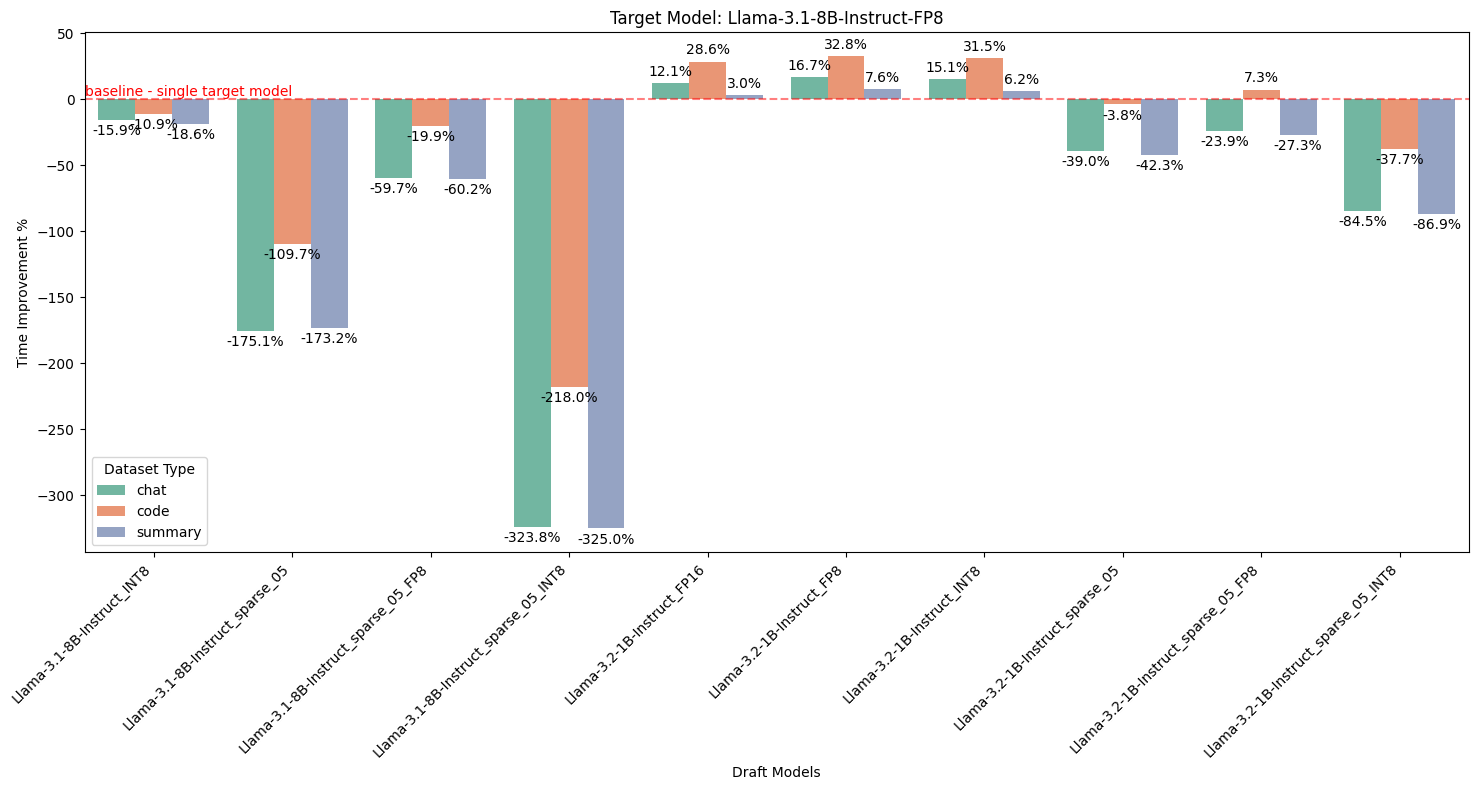

In [71]:
PALETTE = "Set2"
baseline_times = df[df["full_draft_name"] == "_"].set_index(
    ["full_target_name", "dataset_type"]
)["time_taken"]


def calculate_improvement(row):
    if row["full_draft_name"] == "_":
        return 0
    baseline = baseline_times.loc[(row["full_target_name"], row["dataset_type"])]
    return (baseline - row["time_taken"]) / baseline * 100


df["time_improvement"] = df.apply(calculate_improvement, axis=1)

plt.figure(figsize=(15, 8))
ax = sns.barplot(
    data=df[df["full_draft_name"] != "_"],
    x="full_draft_name",
    y="time_improvement",
    hue="dataset_type",
    palette=PALETTE,
)

for i in ax.containers:
    ax.bar_label(i, fmt="%.1f%%", padding=3)

plt.title("Target Model: Llama-3.1-8B-Instruct-FP8")
plt.xlabel("Draft Models")
plt.ylabel("Time Improvement %")
plt.axhline(y=0, color="r", linestyle="--", alpha=0.5)
plt.text(
    x=plt.xlim()[0],
    y=0,
    s="baseline - single target model",
    ha="left",
    va="bottom",
    color="r",
)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset Type")
plt.tight_layout()
plt.show()

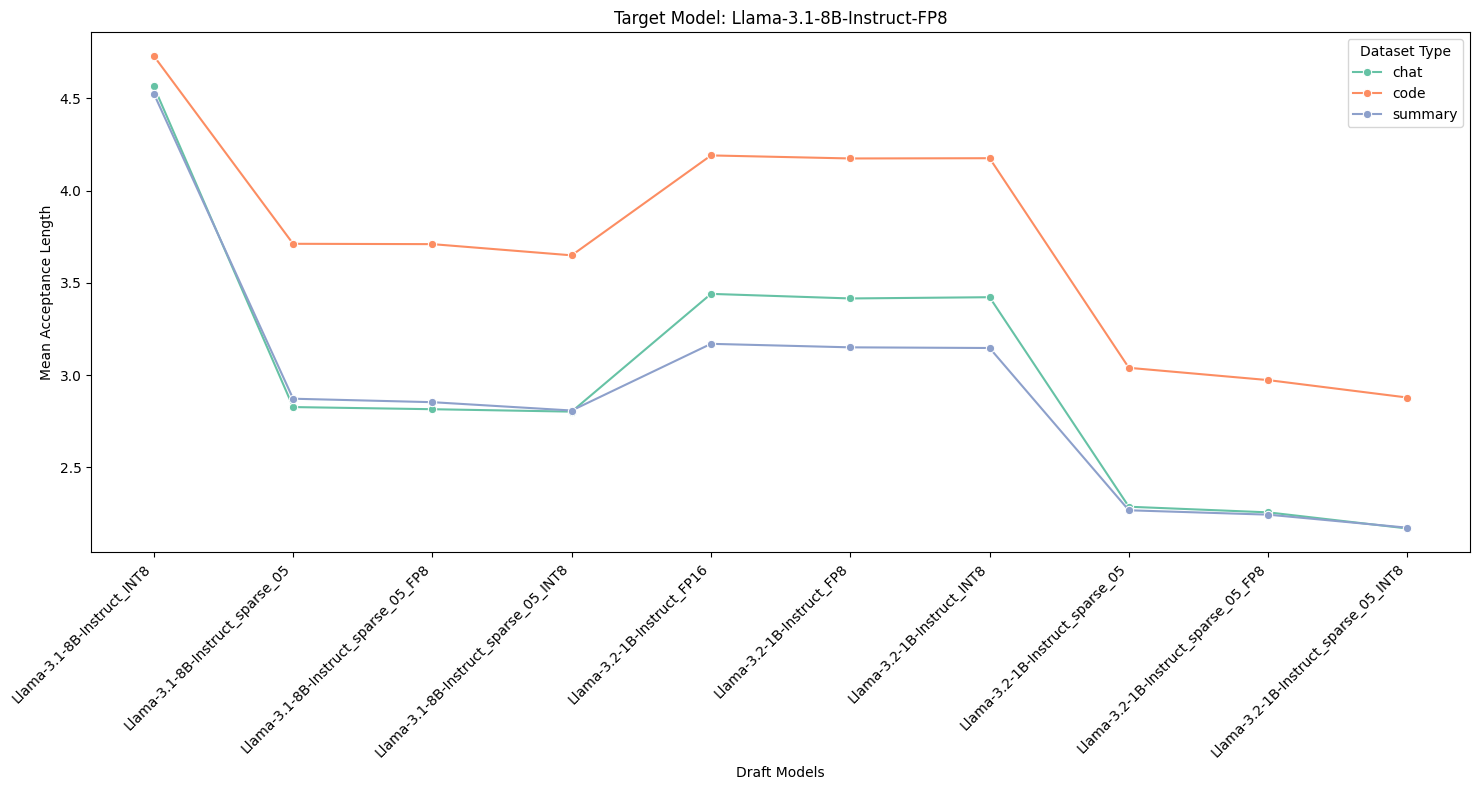

In [59]:
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=df[df["full_draft_name"] != "_"],
    x="full_draft_name",
    y="mean_acceptance_length",
    hue="dataset_type",
    palette=PALETTE,
    marker="o",
)


plt.title("Target Model: Llama-3.1-8B-Instruct-FP8")
plt.xlabel("Draft Models")
plt.ylabel("Mean Acceptance Length")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset Type")
plt.tight_layout()
plt.show()